<a href="https://colab.research.google.com/github/cyprus09/DenoisingAutoencoders/blob/main/Denoising_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import  cifar10

In [ ]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data( )

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
#convert data to floats

train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.
len(train_data_clean)
len(test_data_clean)

10000

In [ ]:
# Adding noise

def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

In [ ]:
len(train_data_noisy)
len(test_data_noisy)

10000

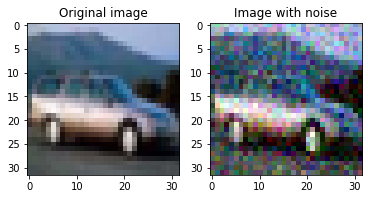

In [ ]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(train_data_clean[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

In [ ]:
#Defining the architecture

def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [ ]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [ ]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)

   return Model(dae_inputs, dae_outputs, name='dae')


In [ ]:
import keras.backend as K

# Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
def loss(y_true,y_pred):
    return K.mean(K.square(y_pred - y_true) + K.mean(y_pred), axis=-1)

    return loss

Using TensorFlow backend.


In [ ]:
# Compiling the model

dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

history = dae.fit(train_data_noisy[:9000], train_data_clean[:9000], validation_data = (test_data_noisy[9000:], test_data_clean[9000:]),

       epochs=100,
       batch_size=128,
       callbacks=[checkpoint])

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.5858
Epoch 00001: val_loss improved from inf to 0.04593, saving model to best_model.h5
71/71 [==============================] - 5s 75ms/step - loss: 0.0107 - accuracy: 0.5858 - val_loss: 0.0459 - val_accuracy: 0.5664
Epoch 2/100
70/71 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.6976
Epoch 00002: val_loss improved from 0.04593 to 0.03526, saving model to best_model.h5
71/71 [==============================] - 4s 62ms/step - loss: 0.0038 - accuracy: 0.6977 - val_loss: 0.0353 - val_accuracy: 0.5923
Epoch 3/100
70/71 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.7236
Epoch 00003: val_loss improved from 0.03526 to 0.02418, saving model to best_model.h5
71/71 [==============================] - 4s 62ms/step - loss: 0.0031 - accuracy: 0.7236 - val_loss: 0.0242 - val_accuracy: 0.6258
Epoch 4/100
70/71 [============================>.] - ETA: 0s - loss: 0.

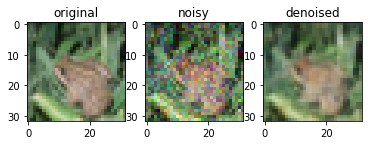

In [ ]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

In [ ]:
#Evaluating the loss
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)

noisy_clean_mse, denoised_clean_mse

(0.009304169346874558, 0.0018928229)

In [ ]:
#Evaluating the model on test data
results = dae.evaluate(test_data_noisy, test_data_clean, verbose=0)

print("test loss, test accuracy :")
print(results)

test loss, test accuracy :
[0.0018928201170638204, 0.7989245057106018]


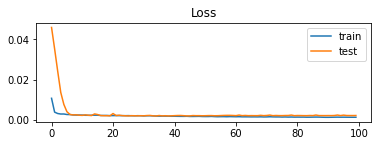

In [ ]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()